In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob

from extract_data import extract_data
from extract_field_goals import extract_field_goals
from extract_kickoffs_and_possessions import extract_kickoffs_and_possessions
from extract_punts import extract_punts
from extract_third_downs import extract_third_downs

pd.set_option("display.max_rows", 50)
# pd.set_option('display.max_colwidth', -1)
%matplotlib inline

def curve_fit(x, y, smoothness=.5):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    results = lowess(y, x, is_sorted=True, frac=smoothness)
    return results[:, 1]

In [2]:
temp = []
data = []
subpxp = []
for year in range(2001,2018):    
    path ='D:/Groups/CalFootball_4thDown/NCAA-Football-Data/' + str(year) + 'PXP' # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
        subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
    data= pd.concat(temp, ignore_index=True)

# Extracting data
pxp = extract_data(data)

## Eliminate bad yardage
pxp['yrdline100'] = pxp['yrdline100'].astype(int)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
## Extracting possession and kickoffs (starting points)
ko_and_poss = extract_kickoffs_and_possessions(pxp.loc[badyard])
# Retrict to first and third quarters
first_and_third_qtr = (ko_and_poss['quarter'] == 1) | (ko_and_poss['quarter'] == 3)
ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]

## Extracting punts
punts = extract_punts(pxp)

## Extracting FG
fgs = extract_field_goals(pxp)

## Extracting Third-down
third_downs = extract_third_downs(pxp)


# 1. Expected Kickoff/Possession EPV (Yard vs. EPV)

In [3]:
# Restrict to kickoff events
ko = ko_and_poss_first_and_third['type'].isin(['Kickoff','Kickoff Return (Defense)','Kickoff Return Touchdown','Kickoff Return (Offense)'])
# Compute the average kickoff value
ekv = ko_and_poss_first_and_third.loc[ko]['PossessionValue'].mean()
print("Expected Kickoff Value: {:.3f} pts".format(ekv))

Expected Kickoff Value: -1.942 pts


In [4]:
# 1. Ignore kickoffs
# 2. Group by yardline 
# 3. Take the average of PossessionValue
# 4. Convert to DataFrame instead of Series
# 5. Make the index a column instead
possession_values = ko_and_poss_first_and_third.loc[~ko].\
    groupby('yrdline100')['PossessionValue'].\
    mean().\
    to_frame()
possession_values.columns = ['rEPV']   # Update column names
possession_values

rEPV
yrdline100          
1           1.223881
2           3.157303
3           2.027972
4           2.460784
5           3.703390
6           3.222222
7           3.294737
8           3.292857
9           3.550633
10          3.241611
11          3.568966
12          3.786517
13          2.948718
14          3.614525
15          3.547619
16          2.990783
17          3.711712
18          3.370213
19          3.595331
20          3.052632
21          2.960630
22          2.996198
23          3.597360
24          3.765101
25          3.160112
...              ...
75          0.139041
76          0.549581
77          0.178139
78          0.279295
79          0.084266
80         -0.118884
81          0.024134
82         -0.330370
83         -0.040469
84         -0.149221
85         -0.042742
86         -0.082075
87         -0.313508
88         -0.158140
89          0.073202
90         -0.180863
91          0.099484
92         -0.308282
93         -0.592937
94         -0.667742
95         -0.272300
96         -0.532637
97         -0.633209
98         -0.944373
99         -0.881640

[99 rows x 1 columns]

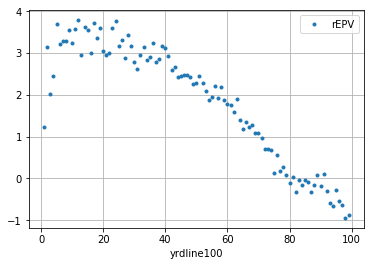

In [5]:
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
ax.grid()

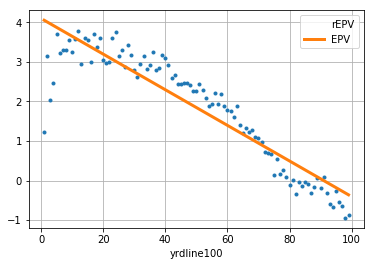

In [6]:
formula = 'rEPV ~ yrdline100'
results = smf.ols(formula, data=possession_values.reset_index()).fit()
# print(results.summary())

possession_values['EPV'] = results.fittedvalues.values
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
possession_values.plot(y='EPV', ax=ax, lw=3)
ax.grid()

epv_model = possession_values['EPV']

# 2.  Expected Conversion Percentage


In [9]:
conv_pct = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct.columns = ['rConvPct']  # update column names
conv_pct

rConvPct
yrdregion distance          
Inside10  0         0.948266
          1         0.661216
          2         0.563801
          3         0.505747
          4         0.468934
          5         0.424806
          6         0.403071
          7         0.414474
          8         0.393701
          9         0.411765
10to20    0         0.949732
          1         0.778364
          2         0.635188
          3         0.585216
          4         0.555079
          5         0.493139
          6         0.469761
          7         0.431391
          8         0.398346
          9         0.393341
Beyond20  0         0.914286
          1         0.755795
          2         0.628376
          3         0.563450
          4         0.535464
          5         0.487179
          6         0.449457
          7         0.418561
          8         0.383904
          9         0.367549

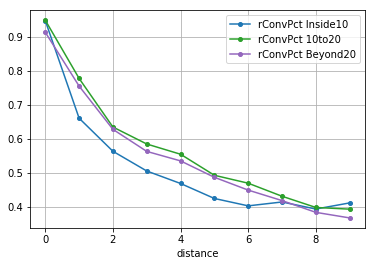

In [10]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C2', '10to20'), ('C4', 'Beyond20')]:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=color, marker='.', ms=8, label='rConvPct ' + region)

ax.legend(loc=1)
ax.grid()

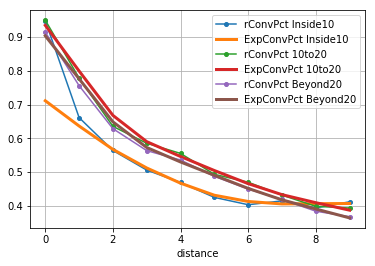

In [12]:
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region = conv_pct.loc[region]
    conv_pct.loc[region, 'ExpConvPct'] = curve_fit(
        conv_pct_region.index, conv_pct_region['rConvPct'])
    
exp_conv_pct_model = conv_pct['ExpConvPct']

fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'Inside10'), (('C2', 'C3'), '10to20'), (('C4', 'C5'), 'Beyond20')]
for (clr1, clr2), region in it:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=clr1, marker='.', ms=8, label='rConvPct ' + region)
    conv_pct.loc[region].plot(
        ax=ax, y='ExpConvPct', color=clr2, lw=3, label='ExpConvPct ' + region)

ax.legend(loc=1)
ax.grid()

# 3. PUNT

In [13]:
punt_dist = punts.\
    groupby('yrdline100')['net_punt_dist'].\
    mean().\
    to_frame()
punt_dist.columns = ['rExpNetPuntDist']  # Update column names
punt_dist

rExpNetPuntDist
yrdline100                 
0                -24.500000
1                -22.000000
3                 -9.000000
5                -55.000000
6                       NaN
7                -41.000000
8                -38.000000
9                -37.000000
10               -19.500000
11               -53.000000
12               -33.000000
13               -35.000000
14               -33.200000
16               -30.000000
17               -32.000000
18                      NaN
19               -47.000000
20               -13.250000
21               -15.000000
22               -10.500000
23                 3.200000
24                -6.500000
25                -2.125000
26               -17.750000
27                11.000000
...                     ...
76                38.010779
77                38.412462
78                38.456584
79                38.586667
80                38.573065
81                39.314088
82                38.831848
83                38.898700
84                38.915759
85                38.536205
86                38.587395
87                38.737674
88                38.668041
89                39.331803
90                38.066237
91                38.705128
92                39.090634
93                38.184588
94                38.826347
95                39.303411
96                37.302158
97                37.294944
98                37.838710
99                35.522523
100               79.000000

[98 rows x 1 columns]

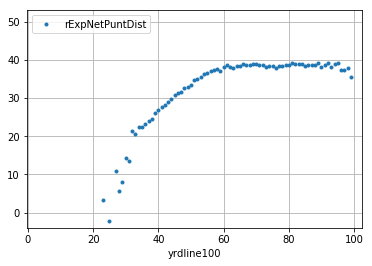

In [16]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

# 4. FIELD GOALS Probability

In [17]:
# 1. Group by distance 
# 2. Take the average success rate
# 3. Convert to DataFrame instead of Series
# 4. Make the index a column instead
fg_prob = fgs.\
    groupby('FieldGoalDistance')['FieldGoalSuccess'].\
    mean().\
    to_frame()
fg_prob.columns = ['rFieldGoalProb']  # Update column names
fg_prob

rFieldGoalProb
FieldGoalDistance                
-43.0                    0.000000
 0.0                     0.151220
 3.0                     0.000000
 4.0                     0.000000
 5.0                     0.000000
 6.0                     0.000000
 7.0                     0.000000
 8.0                     0.000000
 9.0                     0.000000
 10.0                    0.500000
 11.0                    1.000000
 15.0                    0.500000
 17.0                    0.884615
 18.0                    0.959770
 19.0                    0.958738
 20.0                    0.943056
 21.0                    0.929032
 22.0                    0.926108
 23.0                    0.910773
 24.0                    0.894855
 25.0                    0.881207
 26.0                    0.853933
 27.0                    0.842011
 28.0                    0.854311
 29.0                    0.827851
...                           ...
 47.0                    0.520945
 48.0                    0.489240
 49.0                    0.532399
 50.0                    0.469667
 51.0                    0.447689
 52.0                    0.470067
 53.0                    0.458874
 54.0                    0.345912
 55.0                    0.295918
 56.0                    0.402985
 57.0                    0.347826
 58.0                    0.208333
 59.0                    0.166667
 60.0                    0.230769
 61.0                    0.222222
 62.0                    0.000000
 63.0                    0.000000
 64.0                    0.500000
 65.0                    0.000000
 66.0                    0.000000
 67.0                    0.000000
 68.0                    0.000000
 79.0                    1.000000
 83.0                    0.000000
 100.0                   0.000000

[67 rows x 1 columns]

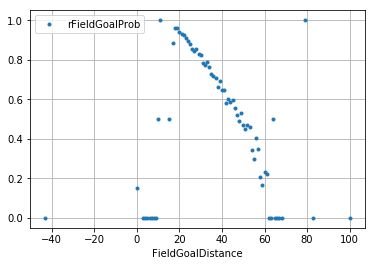

In [18]:
ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
ax.legend(loc=0)
ax.grid()

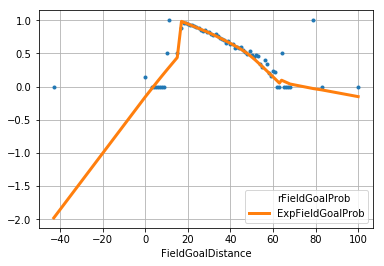

In [42]:
under_63_above_17_mask = ((fg_prob.index <= 63)&(fg_prob.index >= 18))
fg_under_63 = fg_prob.loc[under_63_above_17_mask]

fg_prob.loc[under_63_above_17_mask, 'ExpFieldGoalProb'] = curve_fit(
    fg_under_63.index, fg_under_63['rFieldGoalProb'])

exp_fg_prob_model = fg_prob.loc[under_63_above_17_mask, 'ExpFieldGoalProb'].copy()

ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
fg_prob.plot(y='ExpFieldGoalProb', ax=ax, lw=3)
ax.grid()

In [43]:
fg_under_63

rFieldGoalProb  ExpFieldGoalProb
FieldGoalDistance                                  
18.0                     0.959770          0.970286
19.0                     0.958738          0.957192
20.0                     0.943056          0.944065
21.0                     0.929032          0.930909
22.0                     0.926108          0.917730
23.0                     0.910773          0.904536
24.0                     0.894855          0.891328
25.0                     0.881207          0.878102
26.0                     0.853933          0.864842
27.0                     0.842011          0.851513
28.0                     0.854311          0.838028
29.0                     0.827851          0.823855
30.0                     0.822757          0.809434
31.0                     0.785714          0.794785
32.0                     0.771179          0.779936
33.0                     0.788584          0.764830
34.0                     0.761616          0.749403
35.0                     0.726141          0.733655
36.0                     0.720348          0.717680
37.0                     0.709023          0.701547
38.0                     0.661554          0.685227
39.0                     0.692233          0.668618
40.0                     0.644675          0.651692
41.0                     0.647752          0.634409
42.0                     0.581531          0.616779
43.0                     0.600656          0.598940
44.0                     0.587973          0.580892
45.0                     0.598600          0.562036
46.0                     0.556962          0.541684
47.0                     0.520945          0.519967
48.0                     0.489240          0.497021
49.0                     0.532399          0.472408
50.0                     0.469667          0.446117
51.0                     0.447689          0.418763
52.0                     0.470067          0.390714
53.0                     0.458874          0.360884
54.0                     0.345912          0.331147
55.0                     0.295918          0.301346
56.0                     0.402985          0.271404
57.0                     0.347826          0.241285
58.0                     0.208333          0.210974
59.0                     0.166667          0.180467
60.0                     0.230769          0.149772
61.0                     0.222222          0.118918
62.0                     0.000000          0.087928
63.0                     0.000000          0.056823